# 推理引擎ONNX Runtime部署

使用推理引擎 ONNX Runtime，读取 onnx 格式的模型文件，对单张图像、视频进行预测。

2024/5/1

## 导入工具包

In [42]:
import onnxruntime
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms


## 载入 onnx 模型，获取 ONNX Runtime 推理器

In [43]:
ort_session = onnxruntime.InferenceSession(r'D:\SanYeQing_Project\wht_sanyeqing_image-Classification\onnx_path\resnet101_sanyeqing_10.onnx')

## 构造输入，获取输出结果

In [44]:
x = torch.randn(1, 3, 224, 224).numpy()
print(x.shape)

(1, 3, 224, 224)


In [45]:
#注意，输入输出张量的名称需要和 torch.onnx.export 中设置的输入输出名对应
# onnx runtime 输入
ort_inputs = {'input': x}

# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]  
print(ort_output.shape)

(1, 10)


In [48]:
ort_output

array([[-0.7262414 , -6.137452  ,  4.2838683 ,  7.660538  , -3.353867  ,
         1.8479066 , -9.4333105 ,  1.3605709 , -0.31987798,  5.07078   ]],
      dtype=float32)

## 预处理

In [49]:
#测试时，我们只使用确定性的图像预处理操作
transform_test = transforms.Compose([transforms.Resize(256),
                                    # 从图像中心裁切224x224大小的图片
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                    ])
        

### 载入测试图像

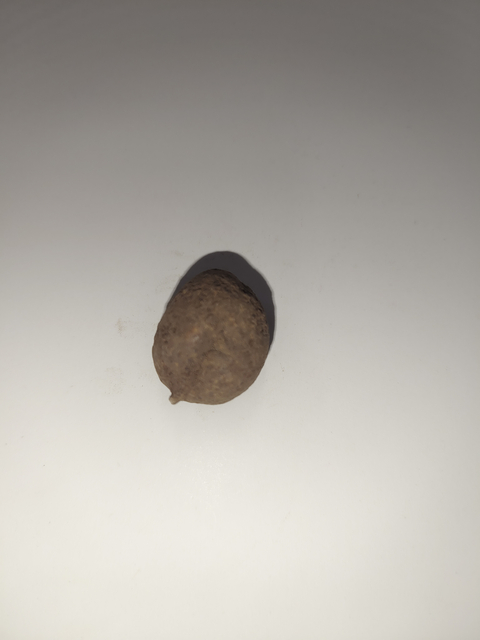

In [65]:
img_path = r"D:\SanYeQing_Project\wht-sanyeqing\test\57.png"
# # 用 pillow 载入
img_pil = Image.open(img_path)
img_pil


## 运行预处理

In [56]:
input_img = transform_test(img_pil)
print(input_img.shape)
input_tensor = input_img.unsqueeze(0).numpy()
print(input_tensor.shape)

torch.Size([3, 224, 224])
(1, 3, 224, 224)


## ONNX Runtime预测

In [57]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

# ONNX Runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)
print(pred_logits.shape)

# 对 logit 分数做 softmax 运算
pred_softmax = F.softmax(pred_logits, dim=1) 
print(pred_softmax)

torch.Size([1, 10])
tensor([[2.3730e-02, 3.0779e-04, 6.1866e-05, 2.9878e-04, 4.2298e-05, 4.6950e-04,
         9.7491e-01, 1.2197e-04, 2.4430e-05, 3.7552e-05]])


## 解析预测结果

In [58]:
# 载入类别和对应 ID
idx_to_labels = pd.read_csv("D:\SanYeQing_Project\wht-sanyeqing\idx_to_labels.csv",encoding='utf-8')
# 创建一个字典来存储真实标签
idx_to_labels = {str(index): row['labels'] for index, row in idx_to_labels.iterrows()}  
print(idx_to_labels)
# classes = {'0': 'GXBS', '1': 'GXGL', '2': 'GXYL', '3': 'GZBJ', '4': 'GZQXN', '5': 'SXXA', '6': 'YNKM', '7': 'YNXSBN', '8': 'ZJTZ', '9': 'ZJWZ'}

# 取置信度最大的 n 个结果
n = 3
top_n = torch.topk(pred_softmax, n)
print(top_n, top_n.indices, top_n.values)

# 预测类别
pred_ids = top_n.indices.numpy()[0]
predicted_class = [idx_to_labels[str(id)] for id in  pred_ids ]
print(pred_ids)
print(predicted_class)

# 预测置信度
confs = top_n.values.numpy()[0]
print(confs)

{'0': 'GXBS', '1': 'GXGL', '2': 'GXYL', '3': 'GZBJ', '4': 'GZQXN', '5': 'SXXA', '6': 'YNKM', '7': 'YNXSBN', '8': 'ZJTZ', '9': 'ZJWZ'}
torch.return_types.topk(
values=tensor([[9.7491e-01, 2.3730e-02, 4.6950e-04]]),
indices=tensor([[6, 0, 5]])) tensor([[6, 0, 5]]) tensor([[9.7491e-01, 2.3730e-02, 4.6950e-04]])
[6 0 5]
['YNKM', 'GXBS', 'SXXA']
[9.7490579e-01 2.3729995e-02 4.6950093e-04]


## 打印预测结果

In [59]:
for i in range(n):
    class_name = idx_to_labels[str(pred_ids[i])] # 获取类别名称
    confidence = confs[i] * 100             # 获取置信度
    text = f'{pred_ids[i]} {class_name} {confidence:.3f}'
    print(text)

6 YNKM 97.491
0 GXBS 2.373
5 SXXA 0.047


# 三叶青分类-ONNX Runtime部署-摄像头

In [69]:
#预测摄像头单帧画面
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)
time.sleep(1)
success, img_bgr = cap.read()
# 关闭摄像头7
cap.release()
# 关闭图像窗口
cv2.destroyAllWindows()

print(img_bgr.shape) #画面转成 RGB 的 Pillow 格式

(480, 640, 3)


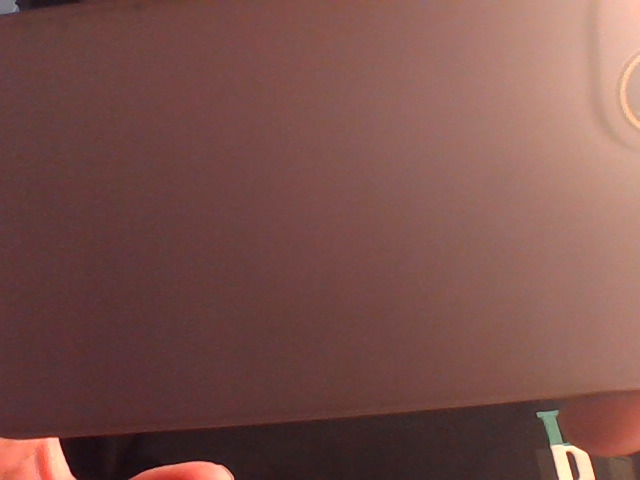

In [70]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
img_pil = Image.fromarray(img_rgb)
img_pil

## 在图像上写预测结果

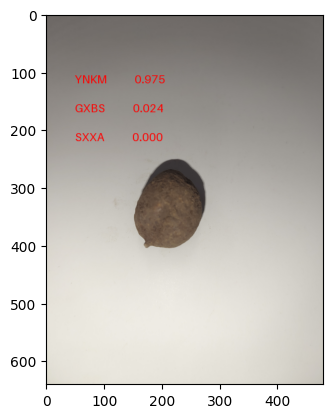

In [66]:

# 创建一个 ImageFont 对象，设置字体大小
font = ImageFont.load_default().font_variant(size=20)

draw = ImageDraw.Draw(img_pil) 
# 在图像上写字
for i in range(len(confs)):
    class_name = idx_to_labels[str(pred_ids[i])] # 获取类别名称
    text = '{:<15} {:>.3f}'.format(class_name, confs[i])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, fill=(255, 0, 0, 1), font=font)
img = np.array(img_pil) # PIL 转 array


plt.imshow(img)
plt.show()